# Sea surface reconstruction from a wave spectrum

In [128]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.signal as signal
import matplotlib.colors as mcolors
import netCDF4 as nc
import os
%matplotlib inline

## Jonswap spectrum and directional distribution

$$
\begin{aligned}
  S(f)     &= \frac{\alpha g^2}{(2\pi)^4 f^5}
              \exp \left( -\beta \left(\frac{f_p}{f}\right)^4 \right)
              \gamma^{\delta} \\
  \delta   &= \exp\left( -\frac{(f-f_p)^2}{2(\sigma_0 f_p)^2} \right) \\
  \sigma_0 &= \left\{
    \begin{array}{lr}
      0.07 & : f <   f_p \\
      0.09 & : f \ge f_p
    \end{array}
  \right.
\end{aligned}
$$



$$
\begin{aligned}
D(f,\theta) &= 0.5 \beta \mathrm{sech}^2 \beta (\theta - \theta_m(f)) \\
\beta &= \left\{
  \begin{array}{lcr}
    2.61 (f/f_p)^{1.3}  & : & 0.56 < f/f_p < 0.95 \\
    2.28 (f/f_p)^{-1.3} & : & 0.95 < f/f_p < 1.16 \\
    10^p             & : & f/f_p > 1.60
  \end{array}
\right. \\
p &= -0.4 + 0.8393 \cdot e^{-0.567 \ln (f/f_p)^2}
\end{aligned}
$$



In [129]:
# jonswap spectrum
def jonswap(frqs, Hs, Tp, gamma=3.3):
    """Returns the JONSWAP spectrum for a given Hs, Tp and frequency array"""
    
    # constants
    fp = 1./Tp
    alpha, beta, g = 8.1E-3, 5./4., 9.8
    
    # it could be vectorized!
    S = np.zeros_like(frqs)
    for i, f in enumerate(frqs):
        if f == 0.:
            S[i] = 0.
        else:
            num = alpha * (g**2)
            den = ((2*np.pi)**4) * f**5
            pm = (num / den) * np.exp(-beta * (fp/f)**4)
            sigma = 0.07 if f <= fp else 0.09
            r = np.exp(-(f - fp)**2 / (2.*(sigma**2)*(fp**2)))
            S[i] = pm * gamma**r
    
    # scale spectrum with zero-order moment 
    m0 = np.trapz(S, x=frqs)
    return (S / m0) * (Hs**2 /16)

In [130]:
# directional wave spectrum 
def directional_wave_spectrum(frqs, dirs, Hs, Tp, mdir, func="cos2s", s=1):
    """Returns the directional wave spectrum"""
     
    # frequency spectrum from jonswap
    S = jonswap(frqs, Hs=Hs, Tp=Tp, gamma=3.3)

    # direction arrays
    dir2 = (dirs - mdir) % 360
    dir3 = dirs - 180

    # cos2s
    if func == "cos2s":
        #
        D = (2. / np.pi) * np.cos((dirs - mdir)*np.pi/180.)**(2*s)
        D[np.logical_and(dir2>90, dir2<270)] = 0.
        E = S[None,:] * D[:,None]
        
    # sech2
    if func == "sech2":
        #
        ffp = frqs*Tp
        beta = np.ones(len(frqs))*1.24
        beta[np.logical_and(ffp>=0.56, ffp<0.95)] = 2.61 * ffp[np.logical_and(ffp>=0.56, ffp<0.95)]**(1.3)
        beta[np.logical_and(ffp>=0.95, ffp<1.60)] = 2.28 * ffp[np.logical_and(ffp>=0.95, ffp<1.60)]**(-1.3)
        E = S[None,:] * (beta[None,:] / 2) * np.cosh(beta[None,:] * (dir3[:,None])*np.pi/180.)**(-2)
        #
        ixd = np.argsort(((dir3 + mdir) % 360))
        E = E[ixd,:]
    
    # scale spectrum with zero-order moment 
    m0 = np.abs(np.trapz(np.trapz(E, x=np.radians(dirs), axis=0), x=frqs))
    return (E / m0) * (Hs**2 / 16)

## Nice representation of the spectrum

In [131]:
# plot wave spectrum
def plot_wave_spectrum(frqs, dirs, E, ax=None, label_angle=-45):
    """Polar representation of a directional wave spectrum"""

    if dirs[-1] != 360.:
        E_copy = E.copy()
        dirs = np.append(dirs, 360)
        E = np.zeros((len(dirs), len(frqs)))
        E[:-1,:] = E_copy
        E[-1,:] = E_copy[0,:]
        
    Fx = frqs[None,:] * np.cos(dirs[:,None]*np.pi/180)
    Fy = frqs[None,:] * np.sin(dirs[:,None]*np.pi/180)
    
    if not ax:
        fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=120)
    
    global cmap
    colors = ["#FFFFFF", "#01DFA5", "#FE642E", "#08298A", "#01A9DB"]
    cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=1024)
    
    smin, smax= -1., 2.
    norm = mcolors.LogNorm(vmin=10**smin, vmax=10**smax)
    
    pc = ax.pcolormesh(Fx, Fy, E, cmap=cmap, norm=norm)
    cf = ax.contour(Fx, Fy, E, np.array([0.25, 0.5, 0.75, 1.0])*E.max(), colors="k")
    
    ax.text(0.50, 0.95, "N", transform=ax.transAxes, ha="center", va="center")
    ax.text(0.95, 0.50, "E", transform=ax.transAxes, ha="center", va="center")
    ax.text(0.50, 0.05, "S", transform=ax.transAxes, ha="center", va="center")
    ax.text(0.05, 0.50, "W", transform=ax.transAxes, ha="center", va="center")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel("$f \, \mathrm{ [Hz]}$")
    
    fmax, fstep = 0.5, 0.1
    ax.set_xlim((-0.4, 0.4))
    ax.set_ylim((-0.4, 0.4))
    
    ticks = np.append(np.arange(-fmax, 0, fstep), np.arange(0, fmax+fstep, fstep)[1:])
    for radii in ticks[ticks > 0]:
        circle = plt.Circle((0,0), radii, color="0.5", linestyle="dashed", fill=False)
        ax.add_artist(circle)
        ax.text(radii*np.cos(np.radians(label_angle)), 
                radii*np.sin(np.radians(label_angle)),
                f"{radii:.1f}")

# Random phase

In [5]:
def randomphase(frqs, dirs, E):
    """Reuturns a function to evaluate the surface elvation for a given spectra"""

    # --- compute 2d frequencies and directions (dirs, frqs)
    frq2d, dir2d = np.meshgrid(frqs, dirs)

    # --- parameters ---
    g = 9.8                                                 # <--- accel. due to grav.
    df = frqs[1] - frqs[0]                                  # <--- delta of frequencies
    dtheta = (dirs[1] - dirs[0]) * np.pi / 180.             # <--- delta of directions
    ampl = np.sqrt(2. * E * df * dtheta)                    # <--- amplitude
    omega = 2. * np.pi * frq2d                              # <--- angular frequency
    kappa = omega ** 2 / g                                  # <--- dispersion relation (deep w.)
    kx = kappa * np.cos(dir2d * np.pi / 180.)               # <--- wavenumber in x
    ky = kappa * np.sin(dir2d * np.pi / 180.)               # <--- wavenumber in y
    phase = np.random.rand(*E.shape) *2. * np.pi - np.pi    # <--- random phase

    def eta(t=0, x=0, y=0):
        n = 0.
        for i in range(len(dirs)):
            for j in range(len(frqs)):
                n += ampl[i,j] * np.cos(kx[i,j]*x + ky[i,j]*y - omega[i,j]*t + phase[i,j])
        return n

    return eta

In [150]:
L, d = 1023, 1 # one kilometer each one meter
xgrd, ygrd = np.meshgrid(np.arange(-L/2, L/2+d, d), np.arange(-L/2, L/2+d, d))

frqs = np.linspace(0,0.5,32)
dirs = np.arange(0, 360+5, 5)

E = directional_wave_spectrum(frqs, dirs, Hs=5, Tp=4, mdir=-120, func="sech2") + \
    directional_wave_spectrum(frqs, dirs, Hs=3, Tp=6, mdir=45, func="sech2")

eta_function = randomphase(frqs, dirs, E)
eta = eta_function(0, xgrd, ygrd)

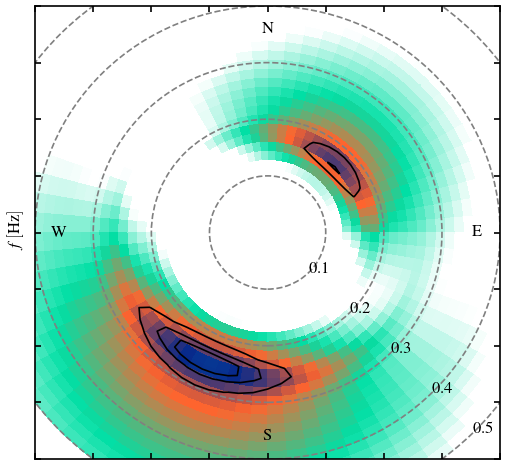

In [151]:
# --- plot target spectrum ---
fig, ax = plt.subplots(1, figsize=(5,5), dpi=120)
plot_wave_spectrum(frqs, dirs, E, ax=ax)

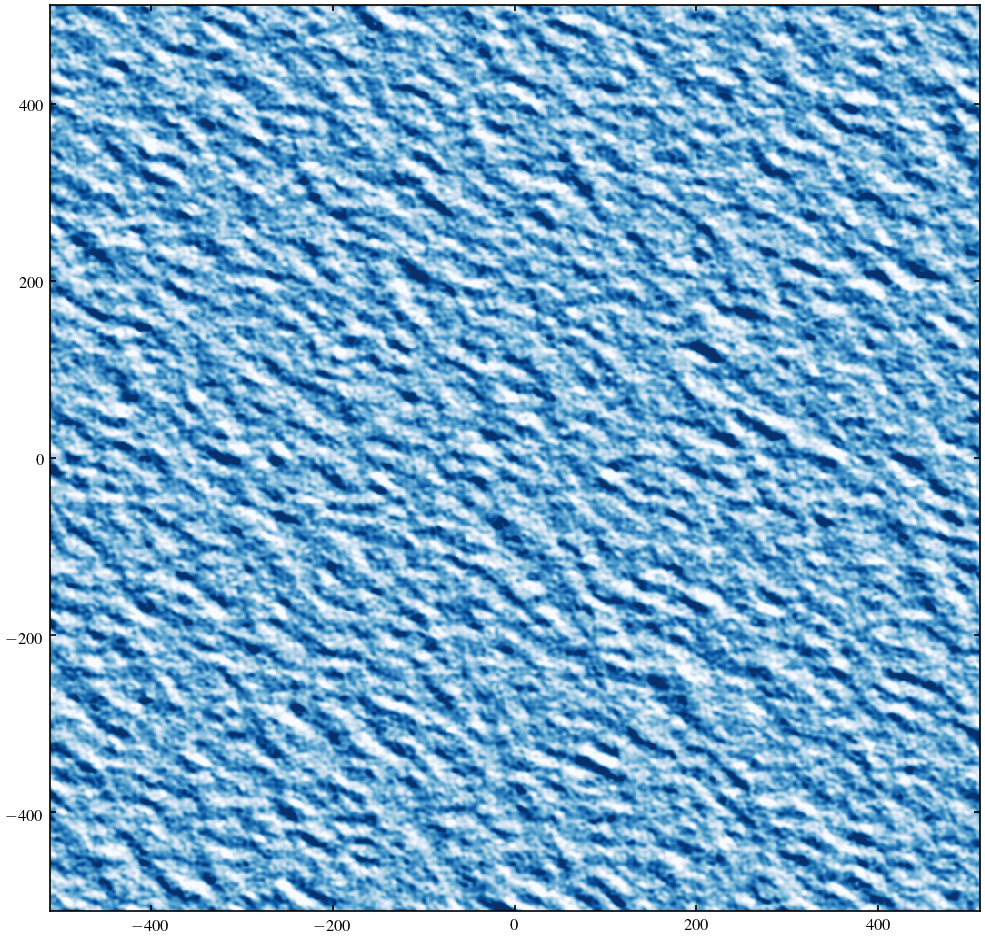

In [152]:
# --- plot surface elevation ---
fig, ax = plt.subplots(1, figsize=(10,10), dpi=120)
ax.pcolormesh(xgrd, ygrd, eta, vmin=-2*eta.std(), vmax=2*eta.std(), cmap="Blues")

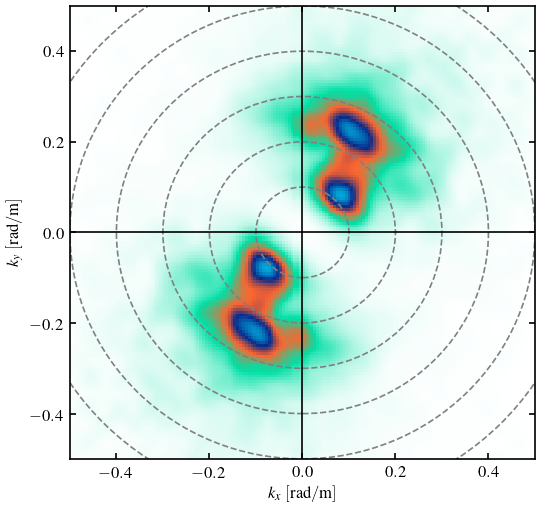

In [153]:
# --- plot resulting spectrum ---
dk = 2 * np.pi / (L+1)
k_nyq = 2 * np.pi / (2 * d)
wnum = np.hstack((np.arange(-k_nyq, -dk, dk), np.arange(0, k_nyq+dk, dk))) - dk

fft = np.fft.fftshift(np.fft.fft2(eta)) / (L+1)**2
power = abs(fft) **2 / dk**2

window = np.hanning(16)[None,:] * np.hanning(16)[:,None]
window = window / window.sum()
power_smooth = signal.convolve2d(power, window, mode='same', boundary='wrap', fillvalue=0)

fig, ax = plt.subplots(1, figsize=(5,5), dpi=120)
ax.pcolormesh(wnum, wnum, power_smooth, cmap=cmap)
ax.axvline(0, color="k")
ax.axhline(0, color="k")
ax.set_xlim((-.5, .5))
ax.set_ylim((-.5, .5))
ax.set_xlabel("$k_x\;\mathrm{[rad/m]}$")
ax.set_ylabel("$k_y\;\mathrm{[rad/m]}$")
for radii in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    circle = plt.Circle((0,0), radii, color="0.5", linestyle="dashed", fill=False)
    ax.add_artist(circle)